In [81]:
import math
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, chi2

DATA_PATH = os.path.join(os.getcwd(), 'data')
FILE_NAME = 'titanic.csv'
COLORS = {
    'PINK': {'STD': "#f31d88d4", 'LIGHT': "#eb8abad5"},
    'BLUE': {'STD': "#3228efd2", 'LIGHT': "#746ef4d3"},
    'SURVIVED': '#32a86d',
    'NOT_SURVIVED': '#ff243d'
}

def get_data(path=DATA_PATH, file=FILE_NAME, **kwargs):
    file_path = os.path.join(path, file)
    return pd.read_csv(file_path, **kwargs)

### Exploratory Data Analysis and Summary Statistics

In [82]:
data = get_data(index_col=0)
SEXES = data.Sex.sort_values().unique()

print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None


There are $891$ entries in the dataset. Most of the variables (columns) are `non-null`, which is good. Though, there are **three** variables which do have `null` entries:
- `Age` => $177$ nulls (**!!!**)
- `Cabin` => $687$ nulls *(variable may be dropped)*
- `Embarked` => $2$ nulls  

As part of the analysis is dedicated to predicting *survival* of the passenger, and age is considered to be one of the core predictors, I should pay more attention to its `null`'s.  

Firstly, we can check the *survival rate* of the passengers with `Age` nulled, comparing them with the other passengers:

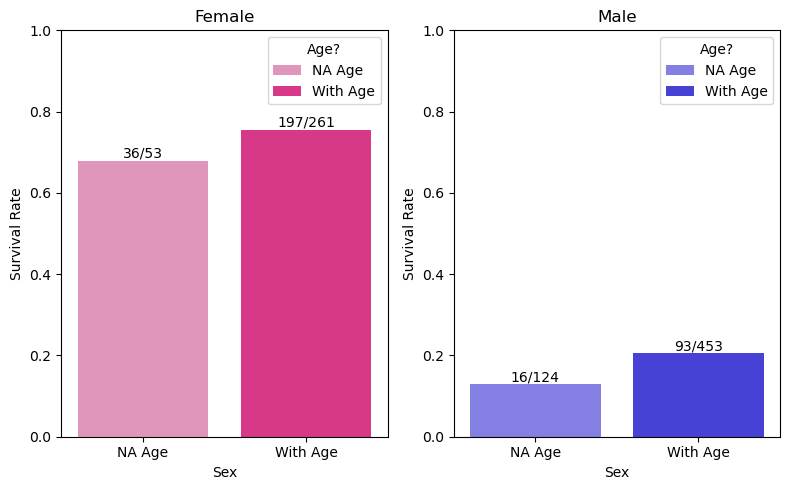

In [83]:
data_age_nac = data.copy()
data_age_nac['Age?'] = ['With Age' if na_age == False else 'NA Age' for na_age in data_age_nac['Age'].isna()]
g_na_age = data_age_nac.groupby(by=['Sex', 'Age?'])['Survived'].agg(['count', 'mean', 'sum'])

sex_t = {'female': None, 'male': None}
for sex in sex_t.keys(): 
    sex_t[sex] = [f'{g_na_age.loc[(sex, age), 'sum']}/{g_na_age.loc[(sex, age), 'count']}' 
                  for age in ['NA Age', 'With Age']]

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 5))
for ax, result in zip(axes, [('female', COLORS['PINK']), ('male', COLORS['BLUE'])]):
	sex, color = result
	subset = g_na_age.loc[sex, :]
	ax = sns.barplot(data=subset.reset_index(), x='Age?', y='mean', 
					 hue='Age?', palette=reversed(color.values()), ax=ax, legend=True)
	ax.set(ylim=(0, 1), ylabel='Survival Rate', xlabel='Sex', title=sex.capitalize())
	for container, label in zip(ax.containers, sex_t[sex]):
		ax.bar_label(container, [label])

plt.tight_layout()
plt.show()

Thus, the survival rate of the passengers with `NA` age is a little bit lower than of those who have their age specified. Let's check if this difference is **statistically significant**, i.e. if it could occur due to random chance.  

We could either use a *random permutation test* or specific types of the hypothesis testing. In that case, when we have two *(assumed)* independent groups with some rate of success *(survived or not)* we could use:
- $Two-Proportion\ z-Test$
- $Chi-Square\ Test\ of\ Independence$  

<small>*To be precise, as our model is <b>2x2</b>, both tests are mathematically equivalent.</small>

To test all of the above, I am going to perform for each `Sex`:
- $Permutation\ Test$
- $Two-Proportion\ z-Test$
- $Chi-Square\ Test\ of\ Independence$

#### Permutation Test

In [84]:
def permutation_test(df, target, group_col, n=int(1.5e3)):
    df = df.copy()
    results = []
    for _ in range(n):
        df[target] = np.random.permutation(df[target])
        gr_mean = df.groupby(group_col)[target].mean()
        a, b = gr_mean.values
        results.append(np.abs(a - b))
    return results

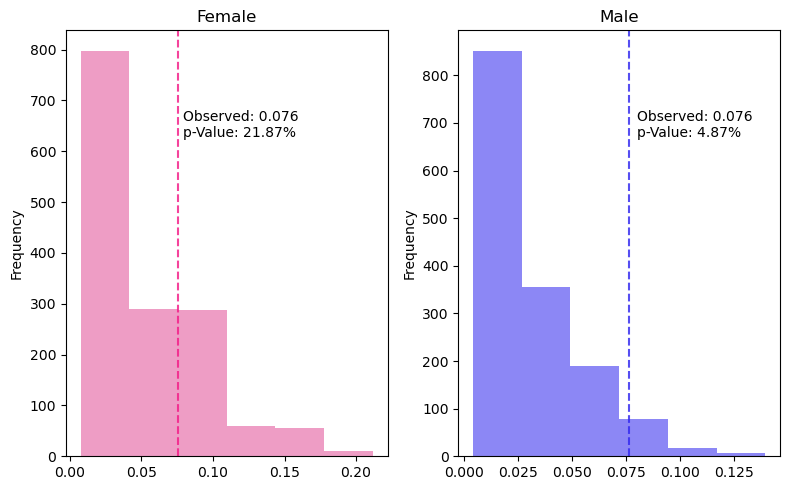

In [85]:
mf_box_cols = ['Survived', 'Age?']
female_box = data_age_nac.loc[data_age_nac['Sex'] == 'female', mf_box_cols]
male_box = data_age_nac.loc[data_age_nac['Sex'] == 'male', mf_box_cols]

female_observed = g_na_age.loc[('female', 'With Age'), 'mean'] - g_na_age.loc[('female', 'NA Age'), 'mean']
male_observed = g_na_age.loc[('male', 'With Age'), 'mean'] - g_na_age.loc[('male', 'NA Age'), 'mean']

perm_test_kwargs = {'target':'Survived', 'group_col': 'Age?'}
female_box_results, male_box_results = permutation_test(female_box, **perm_test_kwargs), permutation_test(male_box, **perm_test_kwargs)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
for ax, result in zip(axes, [('Female', female_box_results, female_observed, COLORS['PINK']), 
                             ('Male', male_box_results, male_observed, COLORS['BLUE'])]):
    title, perms, observed, color = result
    ax.hist(x=perms, bins=6, color=color['LIGHT'])
    ax.set(ylabel='Frequency', title=title)

    pValue = np.mean(np.array(perms) > observed)
    ax.axvline(x=observed, linestyle='--', color=color['STD'])
    ax.text(x=observed*1.05, y=ax.get_ylim()[1]*.75, s=f'Observed: {observed:.3f}\np-Value: {pValue*100:.2f}%')


plt.tight_layout()
plt.show()

#### Two-Proportion z-Test

In [86]:
def two_proportion_z(x1, x2):
    n1, n2 = len(x1), len(x2)
    p1, p2 = np.mean(x1), np.mean(x2)
    p = np.mean(np.concatenate([x1, x2]))
    return (p1 - p2)/np.sqrt(p*(1-p)*(1/n1 + 1/n2))

In [87]:
female_z = two_proportion_z(female_box.loc[female_box['Age?']=='NA Age', 'Survived'].values, 
                            female_box.loc[female_box['Age?']=='With Age', 'Survived'].values)
male_z = two_proportion_z(male_box.loc[male_box['Age?']=='NA Age', 'Survived'].values, 
                          male_box.loc[male_box['Age?']=='With Age', 'Survived'].values)

print('According to "Two-Proportion z-Test"')
print('the probability to observe such a difference is:')
for z in [('Female', female_z), ('Male', male_z)]:
    sex, zValue = z
    prob = norm.cdf(zValue) * 2
    print(f'\tfor {sex} group: {prob*100:.2f}% (z-statistic = {zValue:.3f})')

According to "Two-Proportion z-Test"
the probability to observe such a difference is:
	for Female group: 25.18% (z-statistic = -1.146)
	for Male group: 5.46% (z-statistic = -1.922)


#### Chi-Square Test of Independence

In [88]:
def chi2_by_hand(observed):
    grand_total = observed.sum()
    row_total = observed.sum(axis=1).reshape(-1, 1)
    column_total = observed.sum(axis=0).reshape(1, -1)
    expected = (row_total * column_total) / grand_total
    return np.sum((observed - expected)**2 / expected)

In [89]:
female_t = g_na_age.loc['female', ['sum', 'count']]
female_t['count'] = female_t['count'] - female_t['sum']
female_chi2 = chi2_by_hand(female_t.values)

male_t = g_na_age.loc['male', ['sum', 'count']]
male_t['count'] = male_t['count'] - male_t['sum']
male_chi2 = chi2_by_hand(male_t.values)

rows, cols = female_t.values.shape
df = (rows-1)*(cols-1)

print('According to "Chi-Square Test of Independence"')
print('the probability to observe such a difference is:')
for chi in [('Female', female_chi2), ('Male', male_chi2)]:
    sex, stat = chi
    prob = 1 - chi2.cdf(stat, df)
    print(f'\tfor {sex} group: {prob*100:.2f}% (chi-square statistic = {stat:.3f})')

According to "Chi-Square Test of Independence"
the probability to observe such a difference is:
	for Female group: 25.18% (chi-square statistic = 1.313)
	for Male group: 5.46% (chi-square statistic = 3.696)


**Results of Significance Testing**:  
Both "$Chi-Square\ Test\ of\ Independence$" and "$Two-Proportion\ z-Test$" show the following results:
- **Females** -> $25.18\%$
- **Males** -> $5.46\%$  

*$Permutation\ Test$ shows a little bit different results but close enough to the measures above.*

Thus, difference in *survival rates* of **Females** is far from being explained by `NA` in `Age` column - such a result could likely happen by chance. As for **Males**, the result of $5.46\%$ is much more extreme, but it is still OK to ignore it *(with some caution)*.

#### What to do with `NA`s within `Age`?
We could think of removing these instances, but it is almost $20\%$ of all the dataset, thus it does not seem to be a brilliant idea.  
Another option is to replace `NA`s with **some other value** (e.g. `median`).  
However, we should be careful as there is another important variable which **stratifies** the dataset - `Pclass`. The simple replacement of all the `NA`s with a total median can introduce some error regarding the passenger class.  

To be more precise, let's look at the distribution of the `Age` by `Pclass`.


        0.25  0.50  0.75
Pclass                  
1       27.0  37.0  49.0
2       23.0  29.0  36.0
3       18.0  24.0  32.0


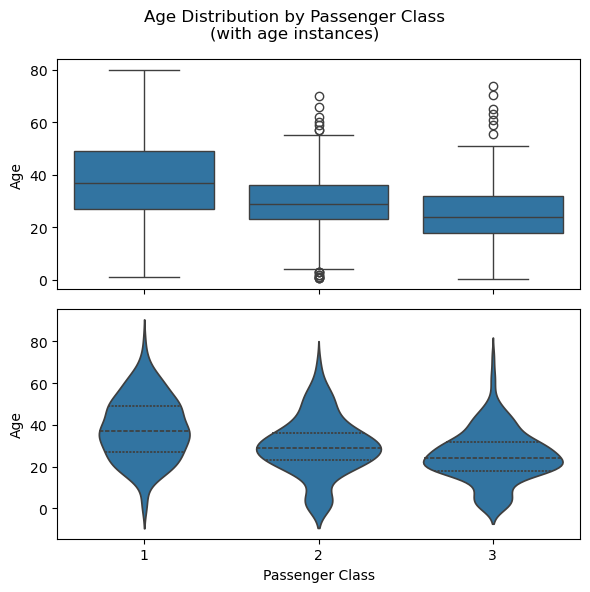

In [90]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 6), sharex=True)
data_with_age = data_age_nac.loc[data_age_nac['Age?'] == 'With Age', :]
print(data_with_age.groupby('Pclass')['Age'].quantile([0.25, 0.5, 0.75]).unstack())

sns.boxplot(x='Pclass', y='Age', data=data_with_age, ax=axes[0])
sns.violinplot(x='Pclass', y='Age', data=data_with_age, inner='quart', ax=axes[1])

fig.suptitle('Age Distribution by Passenger Class\n(with age instances)')
axes[1].set(xlabel='Passenger Class')
plt.tight_layout()
plt.show()

Well, the distribution above shows that `Age` has some relationship with `Pclass`: *the lower the class, the younger the passengers*.  

Let's also compare the density of `Pclass` within `NA` and `not NA` values of the `Age` variable.

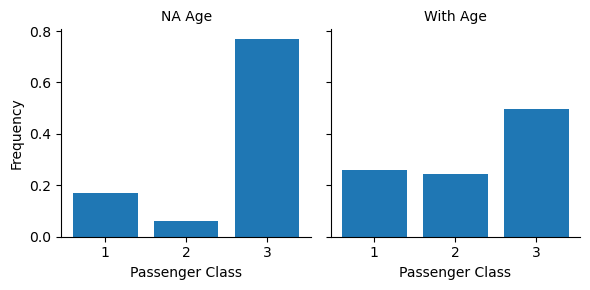

In [91]:
fg_data = data_age_nac.groupby(by=['Pclass', 'Age?']).size().reset_index()
fg_data.columns = ['Pclass', 'Age?', 'Frequency']
fg_data['Frequency'] = fg_data['Frequency'] / fg_data.groupby(by=['Age?'])['Frequency'].transform('sum')

fg = sns.FacetGrid(data=fg_data, col='Age?', col_wrap=2, sharex=True, sharey=True)
fg.map(plt.bar, 'Pclass', 'Frequency')
fg.set_axis_labels('Passenger Class', 'Frequency')
fg.set_titles('{col_name}')

plt.tight_layout()
plt.show()

#### Filling `NA`s in `Age` with respective median `Age` by `Pclass` and  `Sex`
The plot above shows that the `NA Age` instances differ enough in their `Passenger Class` distribution. Thus, I think, it is a better idea to replace the `NA` values with respective `Passenger Class` median age.  

An additional option is to introduce one more level - `Sex`. I guess, that is what I am to do.

In [92]:
def my_imputer(g):
    data_na_age.loc[g.index, 'Age'] = median_ages.loc[g.name]

data_na_age = data_age_nac.loc[data_age_nac['Age?'] == 'NA Age', :]
median_ages = data_with_age.groupby(by=['Pclass', 'Sex'])['Age'].median()

data_na_age.groupby(by=['Pclass', 'Sex']).apply(my_imputer, include_groups=False)

data_cleaned = data.copy()
data_cleaned.loc[data_na_age.index, 'Age'] = data_na_age['Age']
# plus additional cleanings
data_cleaned.drop('Cabin', axis='columns', inplace=True)
data_cleaned.fillna({'Embarked': data_cleaned['Embarked'].value_counts().index[0]}, inplace=True)
# print
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 108.9+ KB


#### The data is finally cleaned :)
Let' perform a little bit more expolarations, and see how **survival rate** depends on the following variables:
- `Sex`
- `Pclass`
- `Age`  

But before we start, let's explore `Age` variable a little bit more, and play around with its distribution a little bit.

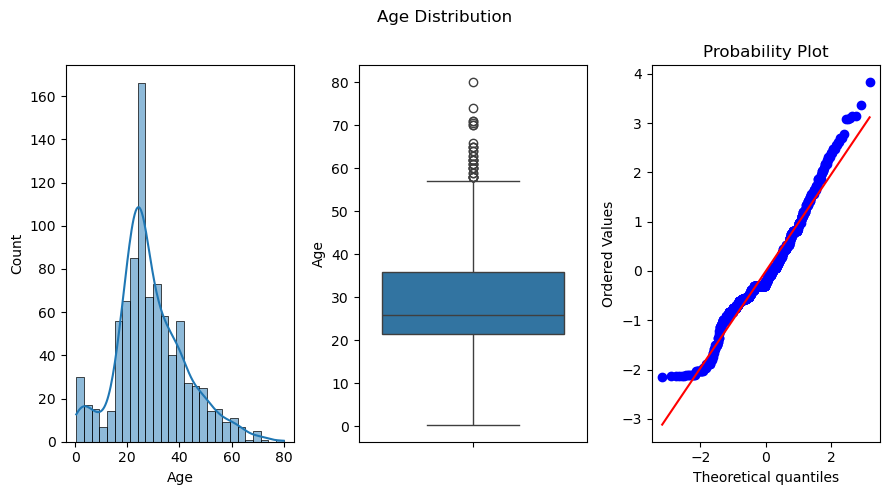

In [93]:
from scipy.stats import probplot
df_age_copy = data_cleaned[['Age']].copy()
df_age_copy['age_z_score'] = (df_age_copy['Age'] - df_age_copy['Age'].mean()) / df_age_copy['Age'].std()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
sns.histplot(data_cleaned['Age'], ax=axes[0], kde=True)
sns.boxplot(y=data_cleaned['Age'], ax=axes[1])
probplot(df_age_copy['age_z_score'], plot=axes[2])

fig.suptitle('Age Distribution')
plt.tight_layout()
plt.show()

The plot above shows that `Age` data is not normally distributed: it does not have a symmetry, and it is skewed to the right. 

I think that there is an important variable we are missing - `Age Bin`. Let's introduce it to the dataset.  

There are few options around it: either set equal distance bins, or introduce custom bins. I am going to choose custom bins because it gives more flexibility *(and common sense)*.  

        Age Bin  count
0  (18.0, 35.0]    514
1  (35.0, 45.0]    135
2  (45.0, 60.0]     81
3  (12.0, 18.0]     70
4   (0.0, 12.0]     69
5   (60.0, inf]     22


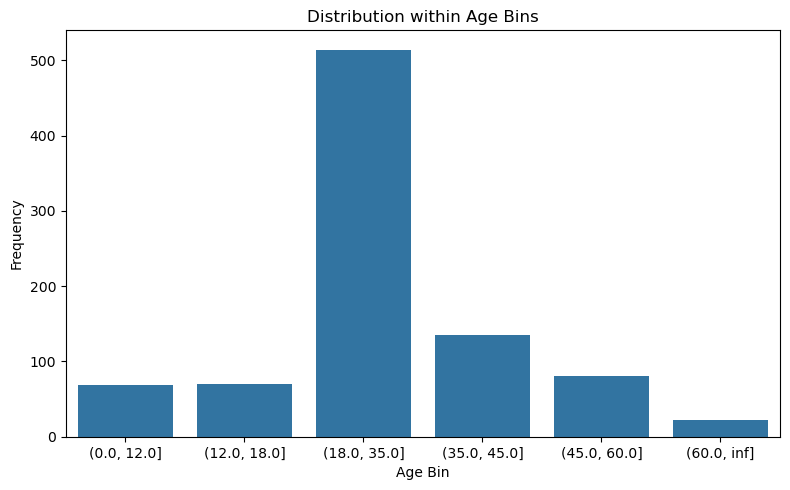

In [94]:
data_cleaned['Age Bin'] = pd.cut(data_cleaned['Age'], bins=[0, 12, 18, 35, 45, 60, np.inf])
df = data_cleaned['Age Bin'].value_counts().reset_index()
print(df)
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=df, x='Age Bin', y='count', ax=ax)
ax.set(ylabel='Frequency', title='Distribution within Age Bins')
plt.tight_layout()
plt.show()

### Getting Close to Prediction Models...
#### Getting More Insights with Visualizations

Let's get sure *(test it)* about what features do influence **survival rate**:
1. `Age`
2. `Passenger Class`
3. `Sex`  

Firstly, I am to visualize these dependencies.  
Secondly, I am going to check the corresponding hypotheses.

#### `Age` vs `Survived`

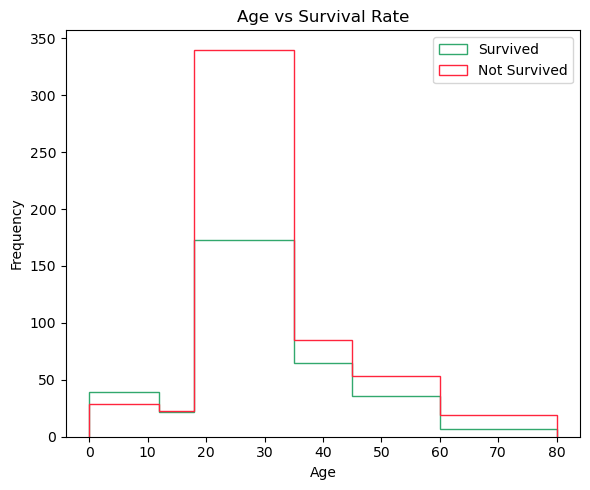

In [95]:
fig, ax = plt.subplots(figsize=(6, 5))
survived = data_cleaned.loc[data_cleaned['Survived'] == 1, 'Age']
not_survived = data_cleaned.loc[data_cleaned['Survived'] == 0, 'Age']

bins = [0, 12, 18, 35, 45, 60, data_cleaned.Age.max()]
ax.hist(survived, bins=bins, histtype='step', color=COLORS['SURVIVED'])
ax.hist(not_survived, bins=bins, histtype='step', color=COLORS['NOT_SURVIVED'])

ax.set(xlabel='Age', ylabel='Frequency', title='Age vs Survival Rate')
ax.legend(['Survived', 'Not Survived'])

plt.tight_layout()
plt.show()

So, pure `Age` is not a great predictor for passenger's survival. Though, we can see that for the bin of $[0, 12]$ there are more survivors. We can play around with this bin trying to decrease the upper bound until we get a significant difference.

#### `Passenger Class` vs `Survived`

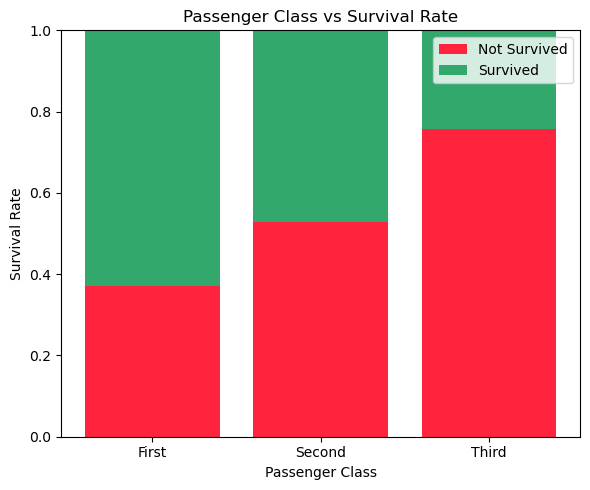

In [96]:
pclass_ct = data_cleaned.groupby(by=['Pclass', 'Survived']).size().unstack()
pclass_ct_pct = pclass_ct.apply(lambda r: r / r.sum(), axis=1)

x = pclass_ct_pct.index.map({1: 'First', 2: 'Second', 3: 'Third'})
fig, ax = plt.subplots(figsize=(6, 5))

ax.bar(x, height=pclass_ct_pct[0], label='Not Survived', color=COLORS['NOT_SURVIVED'])
ax.bar(x, height=pclass_ct_pct[1], bottom=pclass_ct_pct[0], label='Survived', color=COLORS['SURVIVED'])
ax.set(ylabel='Survival Rate', xlabel='Passenger Class', title='Passenger Class vs Survival Rate', ylim=(0, 1))
ax.legend(['Not Survived', 'Survived'])

plt.tight_layout()
plt.show()

The difference seems pretty significant *(I will check significance a bit later)*, thus `Passenger Class` should be considered a strong predictor of the survival rate. Notice, that for the **Second** class the chance of survival is pretty fair. 

#### Diving Deeper: *Male vs Female* Survival Rate by Passenger Class

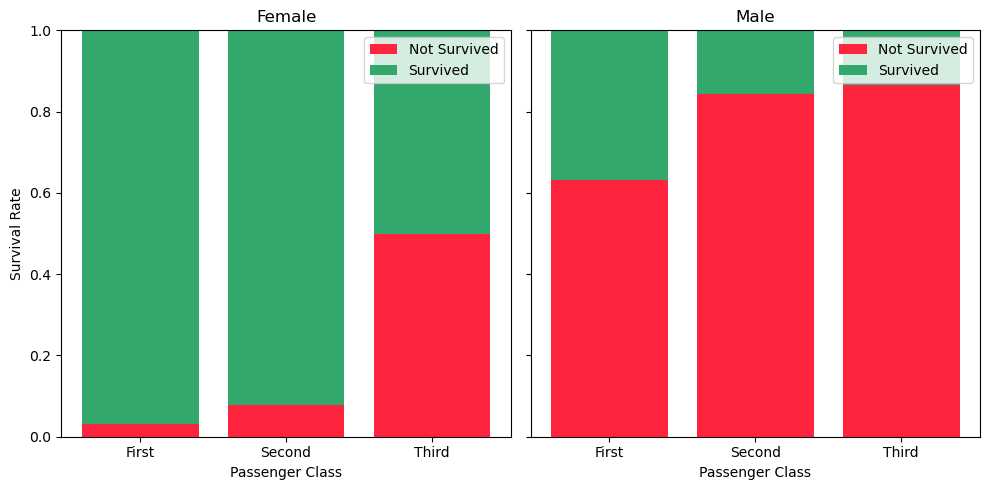

In [97]:
pclass_sex_ct = data_cleaned.groupby(by=['Sex', 'Pclass', 'Survived']).size().unstack()
pclass_sex_ct_pct = pclass_sex_ct.apply(lambda r: r / r.sum(), axis=1)

def my_bar(ax, df, sex):
    not_survived, survived = df[0], df[1]
    ax.bar(x=x, height=not_survived, label='Not Survived', color=COLORS['NOT_SURVIVED'])
    ax.bar(x=x, height=survived, bottom=not_survived, label='Survived', color=COLORS['SURVIVED'])
    ax.legend(['Not Survived', 'Survived'])
    ax.set(xlabel='Passenger Class', title=sex, ylim=(0, 1))

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharey=True)
for container in zip(axes, ['female', 'male']):
    ax, sex = container
    df = pclass_sex_ct_pct.loc[sex, :]
    my_bar(ax=ax, df=df, sex=sex.capitalize())

axes[0].set_ylabel('Survival Rate')

plt.tight_layout()
plt.show()

The survival rate of **female** passengers from the **First** and **Second** classes is astonishing. Also, recollect from the previous plots *(Age Distribution by Passenger Class)* that **First** class is the oldest one: it has the highest median age and a tiny fraction of *passengers under 20*, while **Second** and **Third** classes have pretty high densities of *passengers under 20*.  

As for the **male** passengers, it makes sense to test the hypothesis of association between `Passenger Class` and `Survival Rate` for them.

<small>As long as I keep inspecting `Age`, I reconsider the idea of dropping `NA Age` instances...</small>

### Hypothesis Testing

I believe that there are a few hypothesis coming from the data that deserve to be tested:
1. `Passenger Class` vs `Survival Rate`  
----------------------------------------------------------------------------------------------------
2. *it is even more interesting to derive another hypothesis from the above one* => `Passenger Class` vs `Survival Rate` **for male passengers**  
----------------------------------------------------------------------------------------------------
3. `Children` vs `Survival Rate` *(a tricky one)* 

#### HT => `Passenger Class` vs `Survival Rate`  
$H_0$: there is no association between the `Passenger Class` and the `Survival Rate`.  
$H_A$: there is the association between the `Passenger Class` and the `Survival Rate`, i.e., variables are not independent, and `Passenger Class` influence `Survival Rate`.

As both of the variables are categorical, and there are three types of the `Passenger Class` it is a good idea to use $Chi-Square\ Test\ of\ Independence$

In [98]:
print('Observed Frequencies:', pclass_ct, sep='\n')
chi2_pclass_sr = chi2_by_hand(pclass_ct.values)
degrees_of_freedom = (pclass_ct.shape[0] - 1) * (pclass_ct.shape[1] - 1)

chi2_prob = 1 - chi2.cdf(chi2_pclass_sr, degrees_of_freedom)
print('\nAccording to Chi-Square Test of Independence')
print(f'the probability to observe such a difference is: {chi2_prob*100:.2f}%')

Observed Frequencies:
Survived    0    1
Pclass            
1          80  136
2          97   87
3         372  119

According to Chi-Square Test of Independence
the probability to observe such a difference is: 0.00%


With the $p\_value=0.00\%$ we reject the $H_0$ -_-  
From the result above we see that there is a very stong association between `Passenger Class` and `Survival Rate` => it is highly unlikely that such a difference in numbers *(frequencies)* could happen by chance.  

#### HT => `Passenger Class` vs `Survival Rate` *(!!!MALES ONLY!!!)* 
$H_0$: there is no association between the `Passenger Class` and the `Survival Rate`.  
$H_A$: there is the association between the `Passenger Class` and the `Survival Rate`, i.e., variables are not independent, and `Passenger Class` influence `Survival Rate`.

We will use $Chi-Square\ Test\ of\ Independence$ once more as it matches our data and purposes.

In [99]:
male_pclass_sr = pclass_sex_ct.loc['male', :]
print('Observed Frequencies:', male_pclass_sr, sep='\n')

chi2_male_pclass_sr = chi2_by_hand(male_pclass_sr.values)
chi2_male_prob = 1 - chi2.cdf(chi2_male_pclass_sr, degrees_of_freedom)
print('\nAccording to Chi-Square Test of Independence')
print(f'the probability to observe such a difference is: {chi2_male_prob*100:.2f}%')

Observed Frequencies:
Survived    0   1
Pclass           
1          77  45
2          91  17
3         300  47

According to Chi-Square Test of Independence
the probability to observe such a difference is: 0.00%


With the $p\_value=0.00\%$ we reject the $H_0$ -_-  

Even though male's `Survival Rate` for the **Second** and **Third** classes are quite equal, the **First** class does make the difference. 

#### HT => `Children` vs `Survival Rate`
$H_0$: there is no association between the `Children` and the `Survival Rate`.  
$H_A$: there is the association between the `Children` and the `Survival Rate`, i.e., variables are not independent, and `Children` influence `Survival Rate`.

Before performing a test, let's play around with visualizations to see if there is a significant difference between the `Survival Rate` and the upper bound of what we consider the child age.

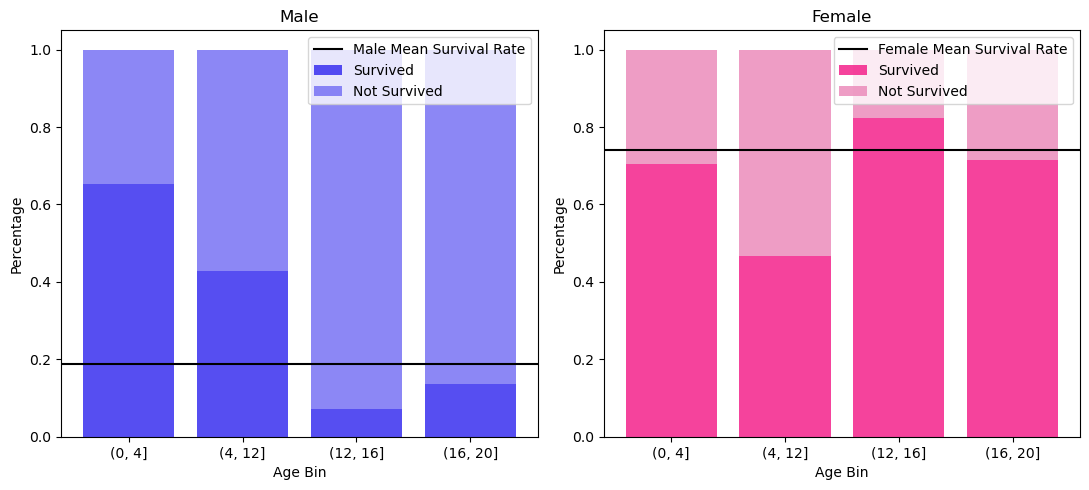

In [100]:
survival_rate = data_cleaned['Survived'].mean()
women_survival_rate, men_survival_rate = data_cleaned.groupby(by='Sex')['Survived'].mean()

df_under_20 = data_cleaned.loc[data_cleaned['Age'] <= 20, ['Sex', 'Survived', 'Age']]
df_under_20['Sex'] = df_under_20['Sex'].str.capitalize()
df_under_20['Age Bin'] = pd.cut(df_under_20['Age'], bins=[0, 4, 12, 16, 20])

def my_stack_bar(data, ax, sex):
    contingency = data.groupby(by=['Age Bin', 'Survived'], observed=False).size().unstack()
    contingency_pct = contingency.apply(lambda r: r / r.sum(), axis=1)
    color1, color0 = COLORS['BLUE'].values() if sex == 'Male' else COLORS['PINK'].values()
    x = contingency_pct.reset_index()['Age Bin'].astype('str')
    ax.bar(x=x, height=contingency_pct[1], color=color1)
    ax.bar(x=x, height=contingency_pct[0], bottom=contingency_pct[1], color=color0)
    hline = men_survival_rate if sex == 'Male' else women_survival_rate
    ax.axhline(hline, color='black')
    ax.set(xlabel='Age Bin', ylabel='Percentage', title=sex)
    ax.legend([f'{sex} Mean Survival Rate', 'Survived', 'Not Survived'])

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(11, 5))
for ax, sex in zip(axes, df_under_20['Sex'].unique()):
    my_stack_bar(df_under_20.loc[df_under_20['Sex'] == sex, :], ax, sex)

plt.tight_layout()
plt.show()

In [101]:
print(df_under_20.groupby(by=['Sex', 'Age Bin', 'Survived'], observed=False).size().unstack())

Survived          0   1
Sex    Age Bin         
Female (0, 4]     5  12
       (4, 12]    8   7
       (12, 16]   3  14
       (16, 20]   8  20
Male   (0, 4]     8  15
       (4, 12]    8   6
       (12, 16]  13   1
       (16, 20]  44   7


You may think that the chart is insightful, but keep in mind **the usual problem with proportion charts** - *they give no information about the frequencies*. 

The matter is that some of the bins are small: indeed, all of the **Female Children** bins are $<30$, the same applies for all of the **Male Children** bins but $(16, 20]$.  

This is why I add that contingency table above. Be careful when infering or making decisions having so few observations. Thus, I'd like to swap to another test.

### `Mean Age` vs `Survival Rate`
$H_0$: there is no association between the `Mean Age` and the `Survival Rate`.  
$H_A$: there is the association between the `Mean Age` and the `Survival Rate`, i.e., variables are not independent, and there is some relationship between `Mean Age` and `Survival Rate`.

As we could see from the charts above, it could make some sense to divide the passengers into `Female` and `Male` again. Another interesting approach may be to divide passengers by classes. 

In [102]:
from scipy.stats import t

def ttest_from_scratch(a, b):
    """Welch's T-Test"""
    a_mean, b_mean = np.mean(a), np.mean(b)
    a_n, b_n = len(a), len(b)
    a_var, b_var = np.var(a, ddof=1), np.var(b, ddof=1)
    t_value = (a_mean - b_mean)/np.sqrt(a_var/a_n + b_var/b_n)
    degrees_of_freedom = (a_var/a_n + b_var/b_n)**2 / ((a_var/a_n)**2/(a_n - 1) + (b_var/b_n)**2/(b_n - 1))
    return t_value, degrees_of_freedom


In [103]:
female_age_sr = data_cleaned.loc[data_cleaned['Sex'] == 'female', ['Survived', 'Age']]
male_age_sr = data_cleaned.loc[data_cleaned['Sex'] == 'male', ['Survived', 'Age']]

male_survived, male_not_survived = male_age_sr.loc[male_age_sr['Survived'] == 1, 'Age'], male_age_sr.loc[male_age_sr['Survived'] == 0, 'Age']
female_survived, female_not_survived = female_age_sr.loc[female_age_sr['Survived'] == 1, 'Age'], female_age_sr.loc[female_age_sr['Survived'] == 0, 'Age']

In [104]:
# FEMALE
female_survived_mean_age = female_survived.mean()
female_survived_std_age = female_survived.std()

female_not_survived_mean_age = female_not_survived.mean()
female_not_survived_std_age = female_not_survived.std()

female_t, female_dof = ttest_from_scratch(female_survived, female_not_survived)
p_value = 2*(1 - t.cdf(np.abs(female_t), female_dof))

print(f'Mean Age of Survived Females: {female_survived_mean_age:.1f}')
print(f'Std of the Age of Survived Females: {female_survived_std_age:.1f}')
print(f'Mean Age of Not Survived Females: {female_not_survived_mean_age:.1f}')
print(f'Std of the Age of Not Survived Females: {female_not_survived_std_age:.1f}')
print('\nAccording to Welch\'s T-Test')
print(f'Probability to observe such the difference is: {p_value*100:.2f}%')
print(f't-statistic is: {female_t:.3f} with {female_dof:.2f} degrees of freedom')

Mean Age of Survived Females: 28.3
Std of the Age of Survived Females: 13.3
Mean Age of Not Survived Females: 24.3
Std of the Age of Not Survived Females: 12.2

According to Welch's T-Test
Probability to observe such the difference is: 1.43%
t-statistic is: 2.479 with 151.14 degrees of freedom


In [105]:
# MALE
male_survived_mean_age = male_survived.mean()
male_survived_std_age = male_survived.std()

male_not_survived_mean_age = male_not_survived.mean()
male_not_survived_std_age = male_not_survived.std()

male_t, male_dof = ttest_from_scratch(male_survived, male_not_survived)
p_value = 2*(1 - t.cdf(np.abs(male_t), male_dof))

print(f'Mean Age of Survived Males: {male_survived_mean_age:.1f}')
print(f'Std of the Age of Survived Males: {male_survived_std_age:.1f}')
print(f'Mean Age of Not Survived Males: {male_not_survived_mean_age:.1f}')
print(f'Std of the Age of Not Survived Males: {male_not_survived_std_age:.1f}')
print('\nAccording to Welch\'s T-Test')
print(f'Probability to observe such the difference is: {p_value*100:.2f}%')
print(f't-statistic is: {male_t:.3f} with {male_dof:.2f} degrees of freedom')

Mean Age of Survived Males: 27.7
Std of the Age of Survived Males: 15.5
Mean Age of Not Survived Males: 30.7
Std of the Age of Not Survived Males: 12.7

According to Welch's T-Test
Probability to observe such the difference is: 6.59%
t-statistic is: -1.853 with 143.68 degrees of freedom


Well, the results are very interesting: 
- **Older Females** were likely to survive.
- **Males** survival rate could be explained by `Age` *(for one-tail test)*  

First of all, look at the `mean` and `standard deviation` - they are not equal, but they are still rather close. Though the chance of such the difference 

Be careful as well as these estimations are not perfect: remember that almost 20% of the dataset had no age specified, and I used medians of respective sex and passenger class to fill these values.  

However, we should admit that some age bins can benefit to the survival rate, while it's highly likely that <u>other variables dominate the chance of survival</u>.

### `Fare` vs `Survival Rate`
$H_0$: there is no association between the `Fare` and the `Survival Rate`.  
$H_A$: there is the association between the `Fare` and the `Survival Rate`, i.e., variables are not independent, and there higher the `Fare` the higher the `Survival Rate`.  

We have already seen that `Passenger Class` is a very good predictor for `Survival Rate`. Thus, let us see if the `Fare` can also help.  
As we could see from the charts above, it could make some sense to divide the passengers into `Female` and `Male` again.

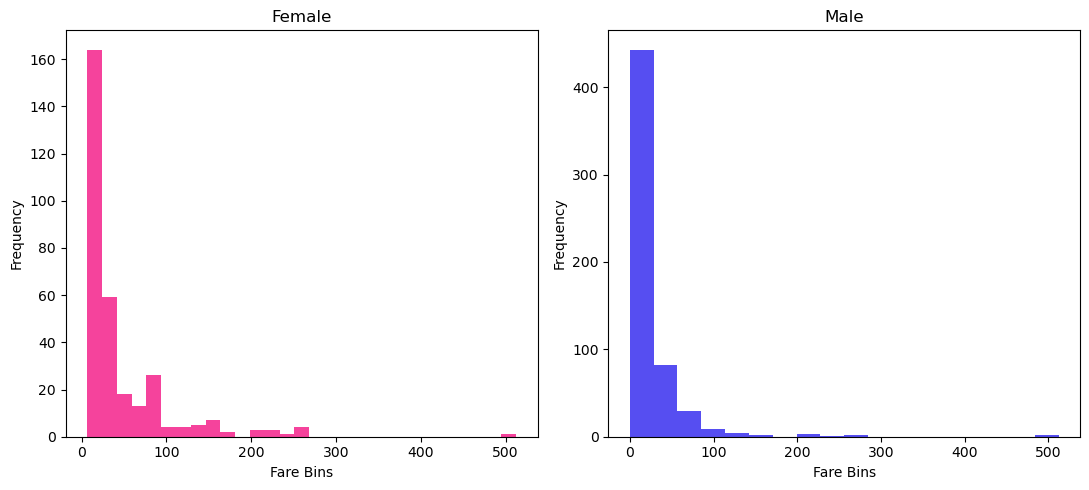

In [106]:
def scotts_bin(a):
    std = a.std()
    denominator = len(a)**(1/3)
    return int(3.5*std/denominator)

female_fare = data_cleaned.loc[data_cleaned['Sex'] == 'female', ['Fare', 'Survived']]
male_fare = data_cleaned.loc[data_cleaned['Sex'] == 'male', ['Fare', 'Survived']]

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(11, 5))
def my_hist(data, sex, ax):
    bins = scotts_bin(data)
    colors = COLORS['PINK'] if sex == 'female' else COLORS['BLUE']
    ax.hist(data, bins=bins, color=colors['STD'])
    ax.set(xlabel='Fare Bins', ylabel='Frequency', title=sex.capitalize())

for ax, data, sex in zip(axes, [female_fare, male_fare], ['female', 'male']):
    my_hist(data['Fare'], sex, ax)

plt.tight_layout()
plt.show()

In [107]:
female_survived_fare = female_fare.loc[female_fare['Survived'] == 1, 'Fare']
female_not_survived_fare = female_fare.loc[female_fare['Survived'] == 0, 'Fare']

female_survived_mean_fare = female_survived_fare.mean()
female_survived_std_fare = female_survived_fare.std()

female_not_survived_mean_fare = female_not_survived_fare.mean()
female_not_survived_std_fare = female_not_survived_fare.std()

female_fare_t, female_fare_dof = ttest_from_scratch(female_survived_fare, female_not_survived_fare)
p_value = 2*(1 - t.cdf(np.abs(female_fare_t), female_fare_dof))

print(f'Mean Fare of Survived Females: {female_survived_mean_fare:.1f}')
print(f'Std of the Fare of Survived Females: {female_survived_std_fare:.1f}')
print(f'Mean Fare of Not Survived Females: {female_not_survived_mean_fare:.1f}')
print(f'Std of the Fare of Not Survived Females: {female_not_survived_std_fare:.1f}')
print('\nAccording to Welch\'s T-Test')
print(f'Probability to observe such the difference is: {p_value*100:.2f}%')
print(f't-statistic is: {female_fare_t:.3f} with {female_fare_dof:.2f} degrees of freedom')

Mean Fare of Survived Females: 51.9
Std of the Fare of Survived Females: 64.1
Mean Fare of Not Survived Females: 23.0
Std of the Fare of Not Survived Females: 24.8

According to Welch's T-Test
Probability to observe such the difference is: 0.00%
t-statistic is: 5.755 with 308.73 degrees of freedom


In [108]:
male_survived_fare = male_fare.loc[male_fare['Survived'] == 1, 'Fare']
male_not_survived_fare = male_fare.loc[male_fare['Survived'] == 0, 'Fare']

male_survived_mean_fare = male_survived_fare.mean()
male_survived_std_fare = male_survived_fare.std()

male_not_survived_mean_fare = male_not_survived_fare.mean()
male_not_survived_std_fare = male_not_survived_fare.std()

male_fare_t, male_fare_dof = ttest_from_scratch(male_survived_fare, male_not_survived_fare)
p_value = 2*(1 - t.cdf(np.abs(male_fare_t), male_fare_dof))

print(f'Mean Fare of Survived Males: {male_survived_mean_fare:.1f}')
print(f'Std of the Fare of Survived Males: {male_survived_std_fare:.1f}')
print(f'Mean Fare of Not Survived Males: {male_not_survived_mean_fare:.1f}')
print(f'Std of the Fare of Not Survived Males: {male_not_survived_std_fare:.1f}')
print('\nAccording to Welch\'s T-Test')
print(f'Probability to observe such the difference is: {p_value*100:.2f}%')
print(f't-statistic is: {male_fare_t:.3f} with {male_fare_dof:.2f} degrees of freedom')

Mean Fare of Survived Males: 40.8
Std of the Fare of Survived Males: 71.4
Mean Fare of Not Survived Males: 22.0
Std of the Fare of Not Survived Males: 32.4

According to Welch's T-Test
Probability to observe such the difference is: 0.80%
t-statistic is: 2.696 with 118.56 degrees of freedom


Well, you see it. `Fare` should not be underestimated. It can be a great predictor!  
However, the data has outliers and it is skewed. I'd like to visualize what has been tested with `Violin Plots` to feel these *probabilities* and *significance* a bit better.

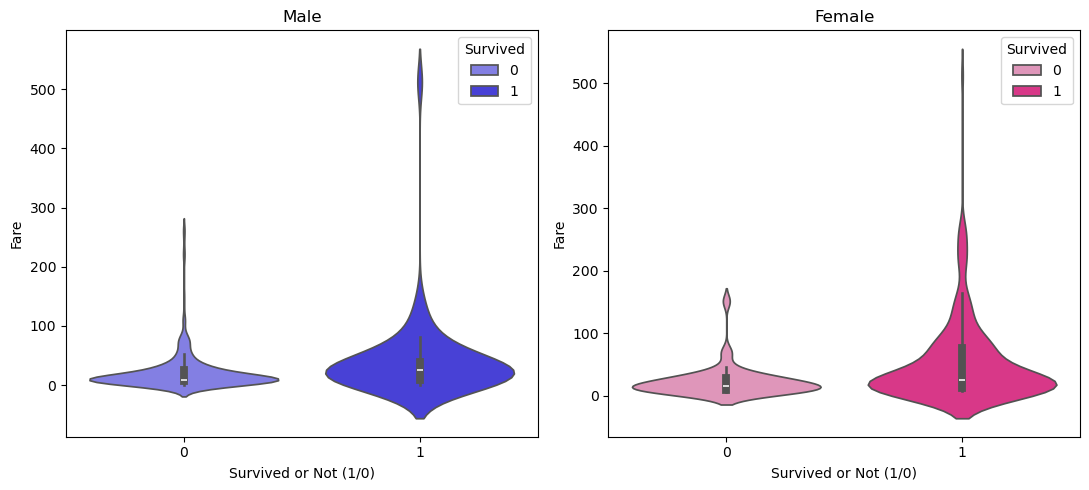

In [109]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(11, 5))
def my_violin(data, x, y, sex, ax):
    colors = COLORS['PINK'].values() if sex == 'female' else COLORS['BLUE'].values()
    sns.violinplot(x=data[x], y=data[y], hue=data[x], inner='box', palette=reversed(colors), ax=ax)
    ax.set(xlabel='Survived or Not (1/0)', ylabel='Fare', title=sex.capitalize())

for ax, data, sex in zip(axes, [male_fare, female_fare], ['male', 'female']):
    my_violin(data, 'Survived', 'Fare', sex, ax)

plt.tight_layout()
plt.show()

Let's do a few more steps to *"comb"* the plot above: I'd like to look at it once more but this time with outliers filtered out.  

To remind: the outlier is a point which is greater than $Q_3+1.5IQR$, where $IQR=Q_3-Q_1$ *(the same holds for $Q_1-1.5IQR$)*.

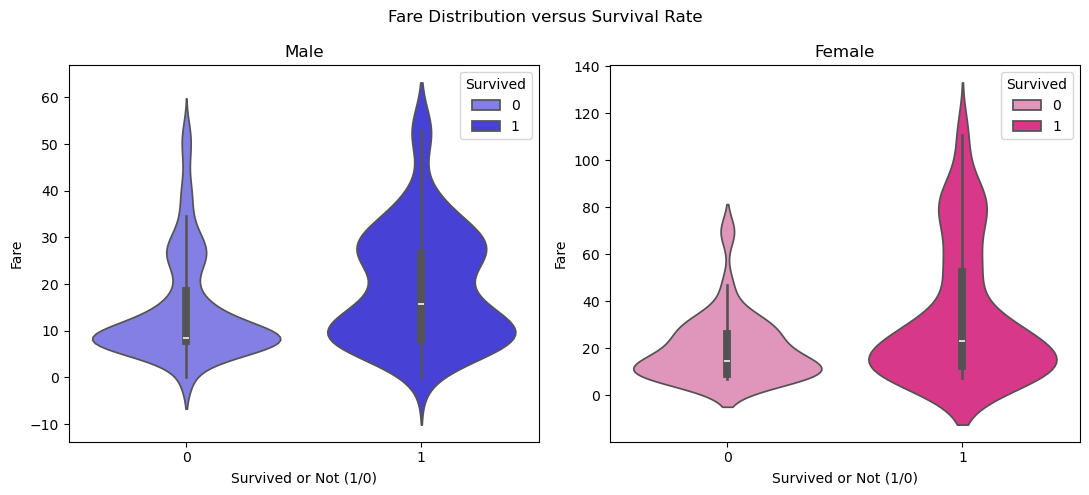

In [110]:
wout_otlrs = []
for original in [male_fare, female_fare]:
    Q3, Q1 = original['Fare'].quantile([0.75, 0.25])
    outlier_threshold = Q3 + 1.5*(Q3 - Q1)
    wout_otlrs.append(original.loc[original['Fare'] <= outlier_threshold, :].copy())

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(11, 5))
for ax, data, sex in zip(axes, wout_otlrs, ['male', 'female']):
    my_violin(data, 'Survived', 'Fare', sex, ax)

plt.suptitle('Fare Distribution versus Survival Rate')
plt.tight_layout()
plt.show()

Without outliers the plot does look like much better.  Let's run the tests of mean independence again - to be sure if there is some difference there.

In [111]:
print('Welch\'s Test of Independence Without Outlier Points In Data')
for sex, data in zip(['Male', 'Female'], wout_otlrs):
    survived, not_survived = data.loc[data['Survived'] == 1, 'Fare'], data.loc[data['Survived'] == 0, 'Fare']
    t_stat, dof = ttest_from_scratch(survived, not_survived)
    p_value = 2*(1 - t.cdf(t_stat, dof))
    print(f'{sex}: p-value = {p_value*100:.2f}%, t-statistic = {t_stat:.3f}, dof = {dof:.3f}')

Welch's Test of Independence Without Outlier Points In Data
Male: p-value = 0.05%, t-statistic = 3.559, dof = 115.149
Female: p-value = 0.00%, t-statistic = 5.470, dof = 267.673


Thus, we see that without outliers things did change:
- for **Male** the p-value decreased from 0.8% to 0.05%, the difference got even more extreme
- for **Female** the difference is observed only within t-statistic value which decreased from 5.755 to 5.470 -> the result got *less extreme* though it remains strongly significant

### Predicting

Any predicting should start from creating **test** and **train** datasets.

In [112]:
data_cleaned['Pclass'] = data_cleaned['Pclass'].astype('str')
data_cleaned['stratify_col'] = data_cleaned['Sex'] + '_' + data_cleaned['Pclass']

data_cleaned['stratify_col'].value_counts()

stratify_col
male_3      347
female_3    144
male_1      122
male_2      108
female_1     94
female_2     76
Name: count, dtype: int64

In [113]:
from sklearn.model_selection import StratifiedShuffleSplit
strat_train, strat_test = None, None
columns = ['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Age Bin']
strat_shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in strat_shuffle_split.split(data_cleaned, data_cleaned['stratify_col']):
    strat_train = data_cleaned.iloc[train_idx, :][columns]
    strat_test = data_cleaned.iloc[test_idx, :][columns]

In [114]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

y_train = strat_train['Survived'].copy()
X_train = strat_train.drop('Survived', axis=1).copy()

numeric_features = ['Fare', 'Age']
cat_features = ['Pclass', 'Sex', 'Age Bin']
preprocessing = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(), cat_features)
])
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessing),
    ('classifier', LogisticRegression(solver='liblinear'))
])

log_reg = pipeline.fit(X_train, y_train)

In [115]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
predictions = pipeline.predict(X_train)

print(confusion_matrix(y_train, predictions, normalize='all'))
print('Recall:', recall_score(y_train, predictions))
print('Precision:', precision_score(y_train, predictions))
print('F-1 Score:', f1_score(y_train, predictions))

[[0.53651685 0.08146067]
 [0.10533708 0.27668539]]
Recall: 0.7242647058823529
Precision: 0.7725490196078432
F-1 Score: 0.7476280834914611


In [116]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3)

results = {
    'Recall': [],
    'Precision': [],
    'F-1 Score': []
}

for train_idx, test_idx in skfolds.split(X_train, y_train):
    pipeline_cln = clone(pipeline)
    lr = pipeline_cln.fit(X_train.iloc[train_idx, :], y_train.iloc[train_idx])
    cv_predictions = pipeline_cln.predict(X_train.iloc[test_idx, :])
    y_true = y_train.iloc[test_idx]
    results['Recall'].append(recall_score(y_true, cv_predictions))
    results['Precision'].append(precision_score(y_true, cv_predictions))
    results['F-1 Score'].append(f1_score(y_true, cv_predictions))

results = pd.DataFrame(results)
print(results)
print(results.mean())

     Recall  Precision  F-1 Score
0  0.703297   0.761905   0.731429
1  0.714286   0.764706   0.738636
2  0.722222   0.783133   0.751445
Recall       0.713268
Precision    0.769914
F-1 Score    0.740503
dtype: float64


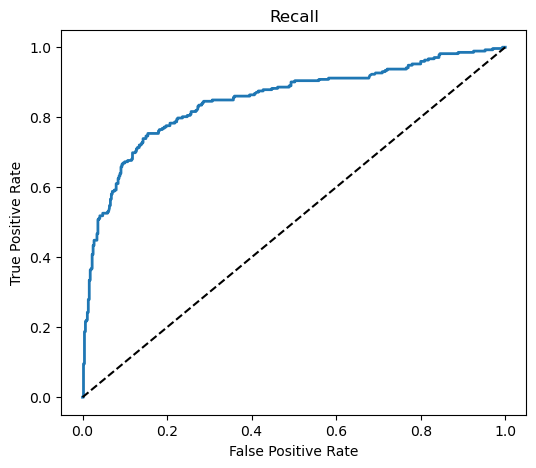

ROC-AUC Score: 0.85


In [117]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score

y_scores = cross_val_predict(pipeline, X_train, y_train,
                             cv=3, method='decision_function')
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(fpr, tpr, linewidth=2, label='ROC')
ax.plot([0, 1], [0, 1], 'k--')
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='Recall')

plt.show()
print(f'ROC-AUC Score: {roc_auc_score(y_train, y_scores):.2f}')

### Regularization

In [118]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': np.arange(0.1, 10, 0.1)
}

random_search = RandomizedSearchCV(pipeline, 
                                   param_distributions=param_distributions,
                                   n_iter=150,
                                   scoring='f1',
                                   error_score='raise',
                                   cv=3)
random_search.fit(X=X_train, y=y_train)
print(f'Previous Mean F-1 Score: {results['F-1 Score'].mean()}')
print(f'Randomized Search Best F-1 Score: {random_search.best_score_}')

Previous Mean F-1 Score: 0.7405033405900457
Randomized Search Best F-1 Score: 0.7438966775721356


In [119]:
random_search.best_params_

{'classifier__penalty': 'l2', 'classifier__C': np.float64(2.8000000000000003)}

In [120]:
best_estimator = random_search.best_estimator_
attributes = best_estimator.named_steps['preprocessor'].get_feature_names_out()
coefs = best_estimator.named_steps['classifier'].coef_
coefs_df = pd.DataFrame(coefs[0], index=attributes, columns=['Coef'])
coefs_df

,Coef
num__Fare,0.056622
num__Age,-0.235129
cat__Pclass_1,1.136238
cat__Pclass_2,-0.014730
cat__Pclass_3,-1.122853
cat__Sex_female,1.326446
cat__Sex_male,-1.327791
"cat__Age Bin_(0.0, 12.0]",0.915354
"cat__Age Bin_(12.0, 18.0]",-0.301493
"cat__Age Bin_(18.0, 35.0]",0.167320


In [121]:
param_distributions_l1 = {
    'classifier__penalty': ['l1'],
    'classifier__solver': ['liblinear'],
    'classifier__C': np.arange(0.1, 10, 0.025) 
}

random_search_l1 = RandomizedSearchCV(estimator=pipeline,
                                      param_distributions=param_distributions_l1,
                                      n_iter=200,
                                      scoring='f1', 
                                      cv=5)
random_search_l1.fit(X=X_train, y=y_train)
print(f'Randomized Search Best F-1 Score: {random_search.best_score_}')
print(f'Randomized Search L1 Best F-1 Score: {random_search_l1.best_score_}')

Randomized Search Best F-1 Score: 0.7438966775721356
Randomized Search L1 Best F-1 Score: 0.7458782293023875


In [122]:
best_estimator_l1 = random_search_l1.best_estimator_
coefs_df_l1 = pd.DataFrame(best_estimator_l1.named_steps['classifier'].coef_[0],
                           index=attributes, columns=['Coef'])
coefs_df_l1

,Coef
num__Fare,0.057075
num__Age,-0.307228
cat__Pclass_1,1.090038
cat__Pclass_2,0.000000
cat__Pclass_3,-1.102798
cat__Sex_female,1.263974
cat__Sex_male,-1.352155
"cat__Age Bin_(0.0, 12.0]",0.734949
"cat__Age Bin_(12.0, 18.0]",-0.226866
"cat__Age Bin_(18.0, 35.0]",0.162985


### Bootstrap Confidence Interval *(using test set)*

In [123]:
from sklearn.utils import resample

X_test = strat_test.drop('Survived', axis=1).copy()
y_test = strat_test['Survived'].copy()

def bootstrap_ci(X, y, estimator, CL=0.95, n_bootstrap=1000):
    """RETURNS {'recall': (lower, upper, all), 'precision': (lower, upper, all)}"""
    assert CL > 0 and CL < 1, 'CL (Confidence Level) should be in the range of (0, 1)'
    results = {'recall': [], 'precision': []}
    for _ in range(n_bootstrap):
        indices = resample(np.arange(len(y)), replace=True, n_samples=len(y))
        X_ = X.iloc[indices, :]
        y_ = y.iloc[indices]
        predictions = estimator.predict(X_)
        results['recall'].append(recall_score(y_, predictions))
        results['precision'].append(precision_score(y_, predictions))
    
    for key, values in results.items():
        values = np.array(values)
        ci_lower = np.quantile(values, (1 - CL) / 2)
        ci_upper = np.quantile(values, 1 - (1 - CL) / 2)
        results[key] = (ci_lower, ci_upper, values)
    return results

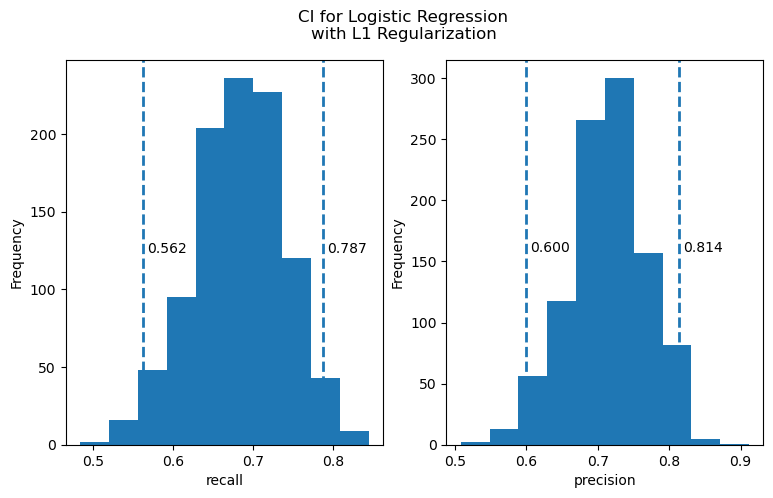

In [124]:
def visualize_bootstrap_ci(X, y, estimator, title):
    results = bootstrap_ci(X, y, estimator)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))

    for result, ax in zip(results.items(), axes):
        key, values = result
        ci_lower, ci_upper, ci_results = values
        ax.hist(ci_results, bins=10)
        for ci in [ci_lower, ci_upper]:
            ax.axvline(ci, linewidth=2, linestyle='--')
            ax.text(ci + .005, y=ax.get_ylim()[1] / 2, s=f'{ci:.3f}')
        ax.set(xlabel=key, ylabel='Frequency')
    
    fig.suptitle(title)
    plt.show()

visualize_bootstrap_ci(X=X_test, y=y_test, estimator=best_estimator_l1,
                       title='CI for Logistic Regression\nwith L1 Regularization')

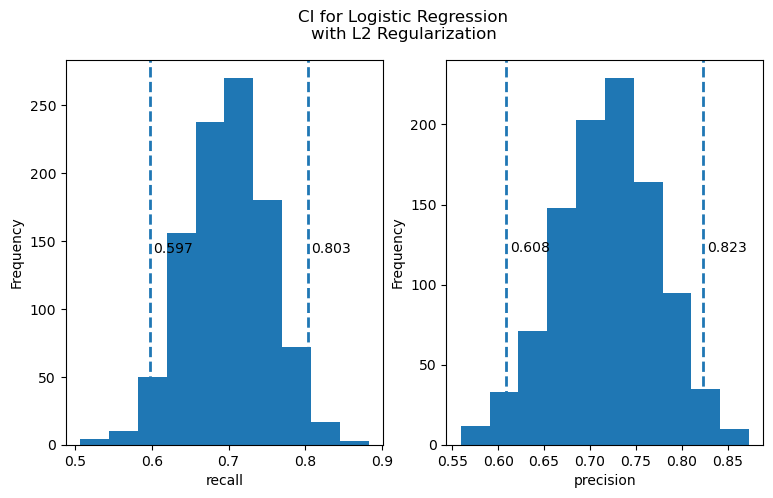

In [125]:
visualize_bootstrap_ci(X=X_test, y=y_test, estimator=best_estimator,
                       title='CI for Logistic Regression\nwith L2 Regularization')

### Tree Models

In [126]:
from sklearn.tree import DecisionTreeClassifier
pipeline_tree = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', DecisionTreeClassifier())
])

tree_params_distribution = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__min_samples_leaf': np.arange(1, 10, 1),
    'classifier__min_samples_split': np.arange(2, 2**4, 2)
}
tree_random_search = RandomizedSearchCV(pipeline_tree,
                                        param_distributions=tree_params_distribution,
                                        scoring='f1',
                                        n_iter=100,
                                        cv=4)
tree_random_search.fit(X_train, y_train)
print(f'Tree Model Best Score: {tree_random_search.best_score_}')

Tree Model Best Score: 0.7667153186509241


In [127]:
print(tree_random_search.best_params_)

{'classifier__min_samples_split': np.int64(6), 'classifier__min_samples_leaf': np.int64(4), 'classifier__criterion': 'gini'}


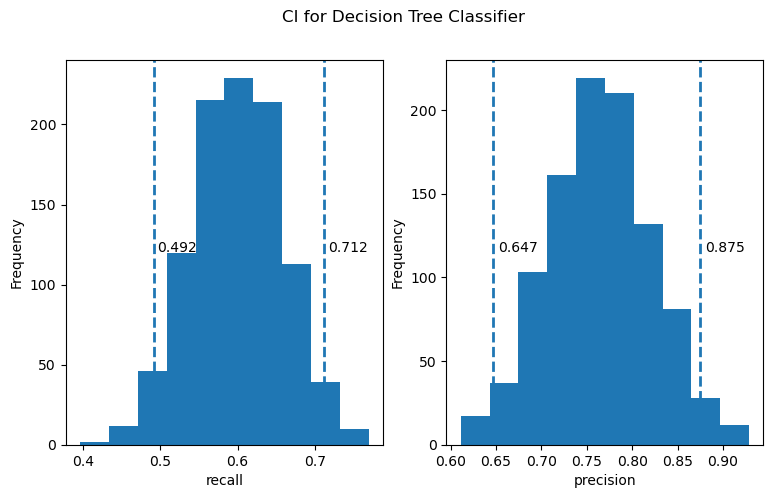

In [128]:
visualize_bootstrap_ci(X=X_test, y=y_test,
                       estimator=tree_random_search.best_estimator_, 
                       title='CI for Decision Tree Classifier')

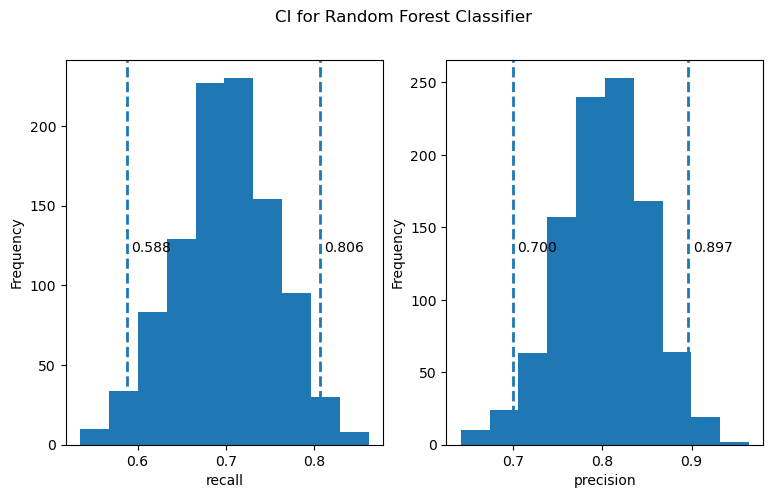

In [129]:
from sklearn.ensemble import RandomForestClassifier
rf_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('classifier', RandomForestClassifier())
])

rf_pipeline.fit(X_train, y_train)

visualize_bootstrap_ci(X=X_test, y=y_test,
                       estimator=rf_pipeline, title='CI for Random Forest Classifier')

In [130]:
pd.DataFrame(rf_pipeline.named_steps['classifier'].feature_importances_,
             index=attributes, columns=['Importance'])

,Importance
num__Fare,0.314593
num__Age,0.229636
cat__Pclass_1,0.028078
cat__Pclass_2,0.017753
cat__Pclass_3,0.051458
cat__Sex_female,0.161648
cat__Sex_male,0.140007
"cat__Age Bin_(0.0, 12.0]",0.022716
"cat__Age Bin_(12.0, 18.0]",0.004395
"cat__Age Bin_(18.0, 35.0]",0.010701


#### Choosing Top N Predictors

In [131]:
def indices_of_top_k(arr, k):
    """Given the array of feature importances, returns the indices of top k features"""
    if k == None: k = math.ceil(np.sqrt(len(arr)) + 1)
    top_k_indices = np.argpartition(np.array(arr), -k)[-k:]
    return np.sort(top_k_indices)

from sklearn.base import TransformerMixin, BaseEstimator

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k=None):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

#### *K*-Nearest Neighbors

In [132]:
from sklearn.neighbors import KNeighborsClassifier
feature_importances = rf_pipeline.named_steps['classifier'].feature_importances_

knghbrs_full_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('feature_selection', TopFeatureSelector(feature_importances=feature_importances)),
    ('classifier', KNeighborsClassifier())
])
knghbrs_param_distributions = {
    'feature_selection__k': [5, 6, 7, 8, 9],
    'classifier__n_neighbors': np.arange(5, 25)
}

knghbrs_random_search = RandomizedSearchCV(estimator=knghbrs_full_pipeline, 
                                           param_distributions=knghbrs_param_distributions,
                                           n_iter=66,
                                           scoring='f1',
                                           cv=5)
knghbrs_random_search.fit(X_train, y_train)

,estimator,Pipeline(step...lassifier())])
,param_distributions,"{'classifier__n_neighbors': array([ 5, 6... 22, 23, 24]), 'feature_selection__k': [5, 6, ...]}"
,n_iter,66
,scoring,'f1'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


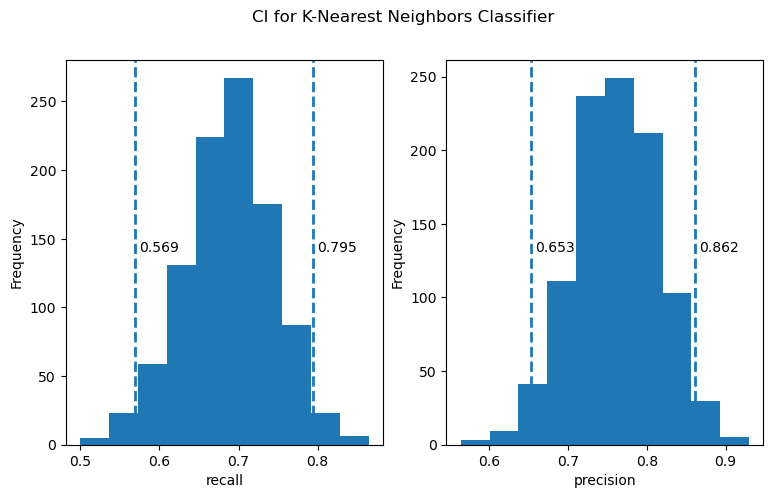

In [133]:
visualize_bootstrap_ci(X=X_test, y=y_test,
                       estimator=knghbrs_random_search.best_estimator_,
                       title='CI for K-Nearest Neighbors Classifier')